In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("../utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [3]:
USE_CUDA = False

## Import data and topology

In [4]:
Timeseries = pd.read_csv('../Data/TimeSeries&Topologies/Lorenz_stochastic_in005_200.csv',encoding='utf-8',header=None)

In [5]:
Timeseries.shape
# 时序， 20个节点，每个节点3个dimension


(20001, 60)

In [6]:
Timeseries[0:10]

0         1         2         3         4         5         6   \
0  0.097540  0.278498  0.546882  0.957507  0.964889  0.157613  0.970593   
1  0.128388 -0.227075  0.516782  1.048973  0.941527  0.114822  0.880432   
2  0.126727  2.776960  0.486139  0.930879  3.049846  0.094019  1.258943   
3  0.431810  2.440966  0.198466  1.031473  2.142674  0.629200  1.830030   
4  0.659814  3.103723  0.521865  1.097211  2.201383  0.880264  2.855455   
5  0.966183  0.059315  0.464020  1.281223 -0.610620  0.387127  4.095414   
6  0.833945  3.983705  0.425084  1.246921 -0.544685  0.379593  5.516500   
7  1.328904  4.474224  0.609042  1.108167  4.533617  0.435131  6.120923   
8  1.807685 -0.521722  0.692678  1.524237  1.711517  0.847737  7.404046   
9  2.018890  1.491390  0.641194  1.813947  1.693260  0.647848  8.888033   

          7         8         9   ...        50        51        52        53  \
0   0.957167  0.485376  0.800280  ...  0.498364  0.959744  0.340386  0.585268   
1   4.549986  0.457578  0.866876  ...  0.464737  0.795437 -3.168443  0.587443   
2   8.285400  0.256572  1.208157  ...  1.007925  0.348807 -2.268277  0.733916   
3  11.253540 -0.134889  1.589173  ...  0.565166  0.117757 -0.749855  0.624407   
4  15.362465  0.632146  2.056179  ...  0.552774  0.047351  3.105421  0.592544   
5  13.651975 -0.024092  2.214297  ...  0.492829  0.382392  6.448658  0.403720   
6  14.433429  0.162791  2.384073  ...  0.324326  1.016321  1.370492  0.595563   
7  17.259620  2.187020  3.411050  ...  0.270082  0.972915  4.619641  0.619882   
8  18.044528  4.570154  4.193370  ...  0.065768  1.411678  8.841028  1.053152   
9  16.848858  4.223507  5.036718  ... -0.597604  2.001848  9.211617  2.743288   

         54        55        56        57         58        59  
0  0.223812  0.751267  0.255095  0.505957   0.699077  0.890903  
1  0.294933  4.930683  0.205565  0.576574   4.173629  0.933877  
2  0.755582  2.155154  0.672647  0.994485   4.498020  0.566817  
3  0.819937  4.341933  0.708891  1.391086   7.080621  1.022630  
4  1.145218  6.239550  0.545974  1.677233   4.825410  1.850426  
5  1.666957  3.805506  1.038077  2.134231   7.953988  1.626423  
6  2.088985  5.925385  1.005022  2.484954  14.971393  2.422625  
7  2.288769  7.044338  0.959681  3.943323  16.973271  6.374376  
8  2.652855  4.521485  1.291632  5.449010  18.387940  5.105895  
9  2.957147  2.215948  1.393786  6.252983  20.220449  6.660834  

[10 rows x 60 columns]

In [7]:
Adj = pd.read_csv('../Data/TimeSeries&Topologies/unweighted_adj_20nodes.csv',encoding='utf-8',header=None)

In [8]:
Adj.shape[0]
print(Adj)

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0    0   0   1   0   0   0   1   0   1   1   0   0   0   0   1   1   0   0   
1    0   0   0   0   1   0   1   0   0   0   0   1   0   0   0   0   0   0   
2    0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   
3    0   1   0   0   0   0   1   0   0   0   1   1   0   0   0   0   0   1   
4    0   1   0   0   0   0   0   0   0   1   0   1   0   0   1   1   0   0   
5    0   0   0   0   0   0   1   0   0   0   0   1   1   0   0   1   0   0   
6    0   0   0   0   0   0   1   0   1   0   0   0   1   0   1   0   0   0   
7    0   0   0   0   0   0   1   1   1   1   0   0   1   0   0   1   1   0   
8    0   1   0   0   0   0   1   0   1   0   0   1   1   0   0   1   0   0   
9    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
10   0   1   0   0   1   1   0   0   0   1   1   1   1   1   1   1   0   0   
11   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  

In [9]:
Num_nodes = 20
Dimension = 3
dim = Dimension*1

In [10]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

print(time.shape)
print(timeseries.shape)

(20001, 60)
(20001, 20, 3)


In [11]:
print(timeseries[0:2])

[[[ 0.0975404   0.27849822  0.54688152]
  [ 0.95750684  0.96488854  0.15761308]
  [ 0.97059278  0.95716695  0.48537565]
  [ 0.80028047  0.14188634  0.42176128]
  [ 0.91573552  0.79220733  0.95949243]
  [ 0.6557407   0.03571168  0.84912931]
  [ 0.93399325  0.67873516  0.75774013]
  [ 0.74313247  0.39222702  0.65547789]
  [ 0.17118669  0.70604609  0.03183285]
  [ 0.27692299  0.04617139  0.09713178]
  [ 0.82345783  0.69482862  0.31709948]
  [ 0.95022205  0.03444608  0.43874436]
  [ 0.38155846  0.76551679  0.7951999 ]
  [ 0.1868726   0.4897644   0.4455862 ]
  [ 0.64631301  0.70936483  0.75468668]
  [ 0.27602508  0.67970268  0.655098  ]
  [ 0.16261174  0.11899768  0.49836405]
  [ 0.95974396  0.34038573  0.58526775]
  [ 0.22381194  0.75126706  0.25509511]
  [ 0.50595705  0.69907672  0.89090325]]

 [[ 0.12838783 -0.22707531  0.51678171]
  [ 1.04897259  0.94152652  0.11482155]
  [ 0.88043215  4.54998619  0.45757834]
  [ 0.86687643  3.36845751  0.39433552]
  [ 0.94973323  0.140311    0.86405225

In [12]:
delt_t = 0.01

## Calculate the numerical difference

In [13]:
timeseries_t0 = timeseries[:-2,:,:]
timeseries_t1 = timeseries[1:-1,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

print(timeseries_t0.shape)
print(timeseries_t1.shape)

(19999, 20, 3)
(19999, 20, 3)


In [14]:
data = np.concatenate((timeseries[:-2,:,:],dXdt),axis=2)
print(data.shape)
print(data[0][0:5])

(19999, 20, 6)
[[ 9.75404050e-02  2.78498219e-01  5.46881519e-01  3.08474289e+00
  -5.05573529e+01 -3.00998078e+00]
 [ 9.57506835e-01  9.64888535e-01  1.57613082e-01  9.14657553e+00
  -2.33620165e+00 -4.27915324e+00]
 [ 9.70592782e-01  9.57166948e-01  4.85375649e-01 -9.01606346e+00
   3.59281924e+02 -2.77973133e+00]
 [ 8.00280469e-01  1.41886339e-01  4.21761283e-01  6.65959597e+00
   3.22657117e+02 -2.74257675e+00]
 [ 9.15735525e-01  7.92207330e-01  9.59492426e-01  3.39977038e+00
  -6.51896328e+01 -9.54401806e+00]]


## Check the topology and edge list (source to target)

In [15]:
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [30]:
edge_index = get_edge_index(Adj) #target to source
print(edge_index)
index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data
print(edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19, 19, 19, 19, 19],
        [ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17]])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
        

## Construct the data, inluding goal and input data

In [17]:
#data = data.reshape((10,-1,4,6))
#goal_data = np.concatenate((data[1:-1,:,0:Dimension],data[0:-2,:,Dimension:Dimension*2]),axis=2)
goal_data = data[1:-1,:,0:Dimension]
print(goal_data.shape)
mapping_data = data[0:-2,:,0:Dimension]
print(mapping_data.shape)

(19997, 20, 3)
(19997, 20, 3)


In [18]:
#tmp1 = np.concatenate([mapping_data[:, i] for i in range(0, mapping_data.shape[1], 1)])
#tmp2 = np.concatenate([goal_data[:, i] for i in range(0, goal_data.shape[1], 1)])
#X = torch.from_numpy(mapping_data)
#y = torch.from_numpy(goal_data)

X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

print(X_train.shape)
print(X_train[0])
print(X_test.shape)

torch.Size([15997, 20, 3])
tensor([[0.0975, 0.2785, 0.5469],
        [0.9575, 0.9649, 0.1576],
        [0.9706, 0.9572, 0.4854],
        [0.8003, 0.1419, 0.4218],
        [0.9157, 0.7922, 0.9595],
        [0.6557, 0.0357, 0.8491],
        [0.9340, 0.6787, 0.7577],
        [0.7431, 0.3922, 0.6555],
        [0.1712, 0.7060, 0.0318],
        [0.2769, 0.0462, 0.0971],
        [0.8235, 0.6948, 0.3171],
        [0.9502, 0.0344, 0.4387],
        [0.3816, 0.7655, 0.7952],
        [0.1869, 0.4898, 0.4456],
        [0.6463, 0.7094, 0.7547],
        [0.2760, 0.6797, 0.6551],
        [0.1626, 0.1190, 0.4984],
        [0.9597, 0.3404, 0.5853],
        [0.2238, 0.7513, 0.2551],
        [0.5060, 0.6991, 0.8909]])
torch.Size([4000, 20, 3])


In [21]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.data import Data, DataLoader

In [22]:
aggr = 'add'
hidden = 100
model = 'Lorenz'
msg_dim = 1
n_f = mapping_data.shape[2]

## Instant model

In [23]:
ogn = SDIunweighted(model, n_f, msg_dim, Dimension, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

type(ogn)

NeuGNN_model.SDIunweighted

## Use these "_over_time" to save estimated values

In [24]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []
ogn = ogn

In [31]:
x=X_train[1]
print(x.shape)
y=y_train[1]
print(edge_index)
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])
print(_q)

torch.Size([20, 3])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19, 19, 19, 19, 19]])
Data(x=[20, 3], edge_index=[2, 100], y=[20, 3])


In [26]:
ogn.loss(_q)

tensor(9.3878, grad_fn=<AddBackward0>)

In [32]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=256,
    shuffle=True
)

In [33]:
print(edge_index)

tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19, 19, 19, 19, 19]])


In [28]:
# for batch in trainloader:
#     x = batch.x  # 节点特征
#     edge_index = batch.edge_index  # 边索引
#     y = batch.y  # 标签
    
#     # 打印数据的形状或查看具体值
#     print(f"x shape: {x.shape}")  # 打印节点特征的形状
#     print(f"edge_index shape: {edge_index.shape}")  # 打印边索引的形状
#     print(edge_index[1])
#     print(f"y shape: {y.shape}")  # 打印标签的形状
    
#     # 访问具体的数值
#     print(f"x values: {x}")  # 打印节点特征的具体值
#     print(f"y values: {y}")  # 打印标签的具体值
#     break

x shape: torch.Size([1280, 3])
edge_index shape: torch.Size([2, 6400])
tensor([   0,    0,    0,  ..., 1279, 1279, 1279])
y shape: torch.Size([1280, 3])
x values: tensor([[ -9.7646, -12.8939,  23.2930],
        [-19.5287, -17.5055,  24.6799],
        [ 11.6651,  13.5808,  17.7173],
        ...,
        [  5.1521,   7.7224,  17.6008],
        [  5.3668,  14.5562,   4.7347],
        [-19.9458, -33.3172,  29.7444]])
y values: tensor([[-13.4906, -12.7123,  24.8628],
        [-18.3372, -17.2532,  26.1208],
        [ 11.4032,  12.6374,  19.5668],
        ...,
        [  5.4293,   9.8551,  16.3633],
        [  5.9074,  16.5117,   3.9369],
        [-18.2012, -31.8329,  34.2811]])


In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [35]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 50

batch_per_epoch = 1000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

1000

In [36]:
epoch = 0
from tqdm import tqdm

In [37]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)
print(edge_index)
#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

# for batch in newtestloader:
#     x = batch.x  # 节点特征
#     edge_index = batch.edge_index  # 边索引
#     y = batch.y  # 标签
    
#     # 打印数据的形状或查看具体值
#     print(f"x shape: {x.shape}")  # 打印节点特征的形状
#     print(f"edge_index shape: {edge_index.shape}")  # 打印边索引的形状
#     print(edge_index[1])
#     print(f"y shape: {y.shape}")  # 打印标签的形状
    
#     # 访问具体的数值
#     print(f"x values: {x}")  # 打印节点特征的具体值
#     print(f"y values: {y}")  # 打印标签的具体值
#     break

tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19, 19, 19, 19, 19]])


c:\Users\1\.conda\envs\network\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [38]:
print(test_idxes.shape)
print(edge_index)

(1000,)
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19, 19, 19, 19, 19]])


In [39]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()
        # print(type(tmp))
        print(tmp.edge_index.shape)
        # print(tmp.edge_index[0])
        # print(tmp.edge_index)
        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        #print(s1)
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        #print(s2)
        tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        print(tmp.shape)
        tmp = tmp.reshape(2,-1)
        tmp = tmp.t()   # tmp has shape [E, 2 * in_channels]
        print(tmp.shape)

        m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((tmp, m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
#     if dim == 1:
#         msg_info['dx'] = msg_info.x1 - msg_info.x2
#         msg_info['dy'] = msg_info.y1 - msg_info.y2
#         msg_info['dz'] = msg_info.z1 - msg_info.z2
#         msg_info['r'] = np.sqrt(
#                 (msg_info.dx)**2(msg_info.dy)**2 + (msg_info.dz)**2)
#     else:
#         msg_info['dx'] = msg_info.x1 - msg_info.x2
#         msg_info['dy'] = msg_info.y1 - msg_info.y2
#         if dim == 2:
#             msg_info['r'] = np.sqrt(
#                 (msg_info.dx)**2 + (msg_info.dy)**2
#             )
#         elif dim == 3:
#             msg_info['dz'] = msg_info.z1 - msg_info.z2
#             msg_info['r'] = np.sqrt(
#                 (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
#             )
    
    return msg_info

In [40]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        print(edge_index)
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_z = ogn.node_fnc_z(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y,self_dyn_z), dim=1)
            columns = ['x','y','z','s1','s2','s3']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info        

In [41]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['x','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['x','y','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['x','y','z','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [42]:
recorded_models = []

## Start training

In [43]:
import sys

for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x

            # sys.exit()
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())

  2%|▏         | 1/50 [00:22<18:17, 22.40s/it]

0.1097200305162165
0.021807285737497042
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

  4%|▍         | 2/50 [00:44<17:56, 22.42s/it]

0.08196735239002104
0.020351814499421896
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

  6%|▌         | 3/50 [01:07<17:31, 22.37s/it]

0.07536564212654087
0.018020040926525652
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

  8%|▊         | 4/50 [01:29<17:08, 22.36s/it]

0.06778294610002454
0.01689796809737323
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 10%|█         | 5/50 [01:51<16:47, 22.39s/it]

0.06490364157498506
0.016443062040669733
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 12%|█▏        | 6/50 [02:14<16:24, 22.38s/it]

0.06342574882307611
0.0160749308061258
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19,

 14%|█▍        | 7/50 [02:36<16:02, 22.37s/it]

0.06175940529871055
0.015649806952191217
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 16%|█▌        | 8/50 [02:59<15:40, 22.39s/it]

0.06015283425629135
0.0152835034221098
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19,

 18%|█▊        | 9/50 [03:21<15:18, 22.41s/it]

0.05920447552137809
0.015180547119315884
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 20%|██        | 10/50 [03:43<14:56, 22.42s/it]

0.058994750201705845
0.015213093715370662
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 22%|██▏       | 11/50 [04:06<14:36, 22.47s/it]

0.05871042607910686
0.015032339091683276
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 24%|██▍       | 12/50 [04:29<14:15, 22.50s/it]

0.0585920550699956
0.01504620663404068
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19,

 26%|██▌       | 13/50 [04:51<13:53, 22.52s/it]

0.058573379101973515
0.015025017062683133
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 28%|██▊       | 14/50 [05:14<13:31, 22.55s/it]

0.058536711548122455
0.015012650614943321
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 30%|███       | 15/50 [05:36<13:09, 22.55s/it]

0.0584804217890068
0.015045269847007733
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 32%|███▏      | 16/50 [05:59<12:45, 22.51s/it]

0.05848306443547133
0.015020107647815506
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 34%|███▍      | 17/50 [06:21<12:22, 22.49s/it]

0.0584375375940359
0.015028084926488364
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 36%|███▌      | 18/50 [06:44<12:03, 22.60s/it]

0.05841525466008254
0.01498885767304107
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 38%|███▊      | 19/50 [07:07<11:43, 22.69s/it]

0.05840172531858581
0.015021499777453496
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 40%|████      | 20/50 [07:30<11:21, 22.71s/it]

0.058177139588860546
0.014910034126894596
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 42%|████▏     | 21/50 [07:53<10:59, 22.74s/it]

0.057879665441615005
0.014849191688388273
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 44%|████▍     | 22/50 [08:15<10:35, 22.69s/it]

0.057765181820087226
0.014872326536353422
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 46%|████▌     | 23/50 [08:38<10:12, 22.68s/it]

0.05774732288318984
0.01488167891149665
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 48%|████▊     | 24/50 [09:00<09:48, 22.62s/it]

0.057714685548981584
0.014854076852159547
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 50%|█████     | 25/50 [09:23<09:24, 22.60s/it]

0.05768525140273718
0.014822084297449167
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 52%|█████▏    | 26/50 [09:46<09:04, 22.69s/it]

0.0576671625536934
0.014922472529851296
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 54%|█████▍    | 27/50 [10:08<08:42, 22.72s/it]

0.05763332448602133
0.014829234351907692
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 56%|█████▌    | 28/50 [10:31<08:18, 22.65s/it]

0.05760047705820175
0.014810911798098828
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 58%|█████▊    | 29/50 [10:53<07:53, 22.57s/it]

0.057593114444477275
0.014837439374825153
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 60%|██████    | 30/50 [11:16<07:30, 22.55s/it]

0.057561544945159984
0.0148258346645674
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 62%|██████▏   | 31/50 [11:38<07:08, 22.54s/it]

0.05754320307911251
0.014812744302436278
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 64%|██████▍   | 32/50 [12:01<06:48, 22.69s/it]

0.0575229970896297
0.0148106715307002
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19, 

 66%|██████▌   | 33/50 [12:24<06:25, 22.66s/it]

0.05751734682118184
0.014820097420018502
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 68%|██████▊   | 34/50 [12:47<06:03, 22.75s/it]

0.05749695956978998
0.014824218796301535
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 70%|███████   | 35/50 [13:09<05:40, 22.68s/it]

0.05746416355316554
0.014814224490804809
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 72%|███████▏  | 36/50 [13:32<05:17, 22.67s/it]

0.05744984111257096
0.014804730055000827
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 74%|███████▍  | 37/50 [13:55<04:55, 22.73s/it]

0.05743901826608492
0.01478824803011174
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 76%|███████▌  | 38/50 [14:18<04:33, 22.77s/it]

0.05740981767973006
0.014783201092248198
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 78%|███████▊  | 39/50 [14:41<04:10, 22.75s/it]

0.05740380281581427
0.01479119501601774
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 80%|████████  | 40/50 [15:03<03:47, 22.79s/it]

0.05738312733309742
0.014787296631778937
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 82%|████████▏ | 41/50 [15:27<03:26, 22.89s/it]

0.057373171479521506
0.014772812779377817
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 84%|████████▍ | 42/50 [15:49<03:02, 22.80s/it]

0.057351446795584286
0.01476586484122618
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 86%|████████▌ | 43/50 [16:12<02:38, 22.71s/it]

0.05734188926512803
0.014777376369644926
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 88%|████████▊ | 44/50 [16:35<02:16, 22.77s/it]

0.05733109760144327
0.014772207520297643
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 90%|█████████ | 45/50 [16:57<01:53, 22.71s/it]

0.05732047912544956
0.01477125673315273
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19

 92%|█████████▏| 46/50 [17:20<01:30, 22.68s/it]

0.05730927582196074
0.014764750394936806
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 94%|█████████▍| 47/50 [17:42<01:08, 22.69s/it]

0.057302648751983244
0.014762899319450356
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

 96%|█████████▌| 48/50 [18:05<00:45, 22.69s/it]

0.05729650524457395
0.014763649235547946
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

 98%|█████████▊| 49/50 [18:28<00:22, 22.68s/it]

0.05729177426329075
0.014762192324761206
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 1

100%|██████████| 50/50 [18:50<00:00, 22.62s/it]

0.057289175285416376
0.014762092748809904
torch.Size([2, 100000])
torch.Size([200000])
torch.Size([100000, 2])
tensor([[ 2,  6,  8,  9, 14, 15, 19,  4,  6, 11,  2, 17,  1,  6, 10, 11, 17, 18,
         19,  1,  9, 11, 14, 15,  6, 11, 12, 15,  6,  8, 12, 14, 18, 19,  6,  7,
          8,  9, 12, 15, 16,  1,  6,  8, 11, 12, 15, 15,  1,  4,  5,  9, 10, 11,
         12, 13, 14, 15, 11,  9, 17,  0,  3,  4,  7, 17,  6,  9, 11, 15,  1, 11,
         12, 16, 18,  2,  3,  7, 10, 11, 13, 16, 17,  3,  7, 14,  5,  6,  8, 11,
         12,  1,  3,  4,  5,  6, 10, 11, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15,
         15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 

In [345]:
#torch.save(ogn, 'Lorenz_N20_intensity1_t50_net.pth')

In [182]:
#ogn = torch.load('Lorenz_N20_intensity1_t150_net.pth')

In [48]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(0.01) # diffusion is sqrt(h)*theta(x0) 

# fig = plt.figure(figsize = (10,6))
# ax1 = fig.add_subplot(2,1,1)
# #ax1.scatter(s.index, s.values)
# ax1.plot(s.index, s.values,'.')
# plt.grid()
 
# ax2 = fig.add_subplot(2,1,2) 
# s.hist(bins=30,alpha = 0.5,ax = ax2)
# s.plot(kind = 'kde', secondary_y=True,ax = ax2)
# plt.title('The standard deviation distribusion')
# plt.grid()

IndexError: list index out of range

In [466]:
import seaborn as sns
import numpy as np
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
 
sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )
np.random.seed(1425)

In [522]:
from matplotlib import colors as mcolors

In [523]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

## Check the accuracy

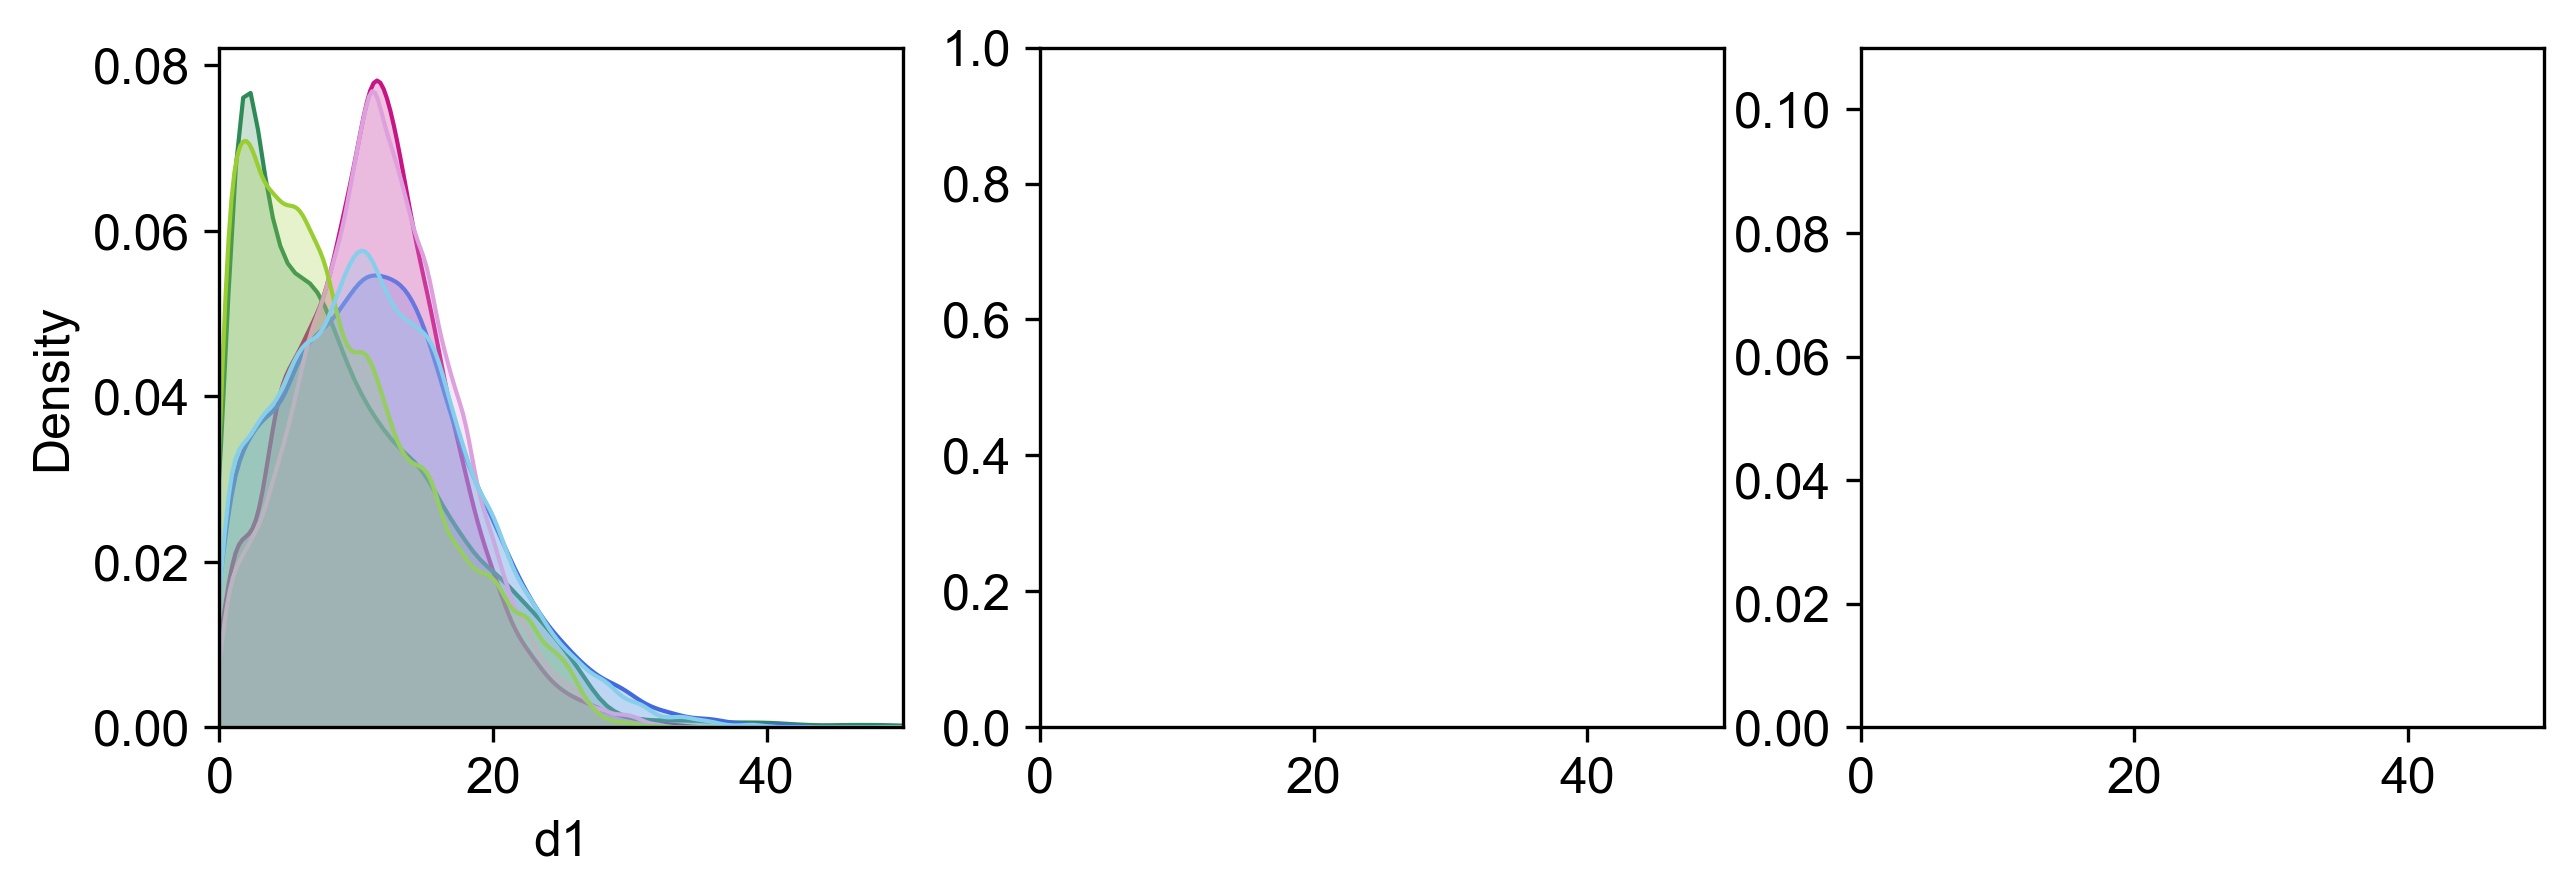

In [540]:
gamma = 1
s = diffusion_new['d1']/np.sqrt(0.01)
s1 = diffusion['x'].abs()/np.sqrt(gamma)
s2 = diffusion_new['d2']/np.sqrt(0.01)
tmp1 = (28-diffusion['z'])/np.sqrt(gamma)
s3 = tmp1.abs()/np.sqrt(gamma)
s4 = diffusion_new['d3']/np.sqrt(0.01)
s5 = diffusion['y'].abs()/np.sqrt(gamma)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(10, 3))
c1, c2, c3 = sns.color_palette('Set1', 3)

sns.kdeplot(s, shade=True, color=colors['mediumvioletred'], label='dist1', ax=ax1)
#sns.kdeplot(s1, shade=True, color=colors['plum'], label='dist2',ax=ax1)
sns.kdeplot(s2, shade=True, color=colors['seagreen'], label='dist1', ax=ax1)
#sns.kdeplot(s3, shade=True, color=colors['mistyrose'], label='dist2',ax=ax1)
sns.kdeplot(s4, shade=True, color=colors['royalblue'], label='dist1', ax=ax1)
#sns.kdeplot(s5, shade=True, color=colors['skyblue'], label='dist2',ax=ax1)

sns.kdeplot(s1, shade=True, color=colors['plum'], label='dist2',ax=ax1)
sns.kdeplot(s3, shade=True, color=colors['yellowgreen'], label='dist2',ax=ax1)
sns.kdeplot(s5, shade=True, color=colors['skyblue'], label='dist2',ax=ax1)
plt.xlim([0, 50])
plt.ylim([0, 0.11])
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_dif_fig2.pdf')

#plot three dimensions' diffusion intensity density in the first subfig.

## Check if the well-trained network can produce the similar trajectories

In [471]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
for i in range(5000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp, y_tmp, z_tmp = ogn.average_trajectories(_q)
    X_tmp = torch.cat((x_tmp,y_tmp,z_tmp), 1)
    if i < X.shape[0]-2:
        X[i+1] = X_tmp
    else:
        break
    x_Update.append(x_tmp.reshape(1,-1))
    y_Update.append(y_tmp.reshape(1,-1))
    z_Update.append(z_tmp.reshape(1,-1))   
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)

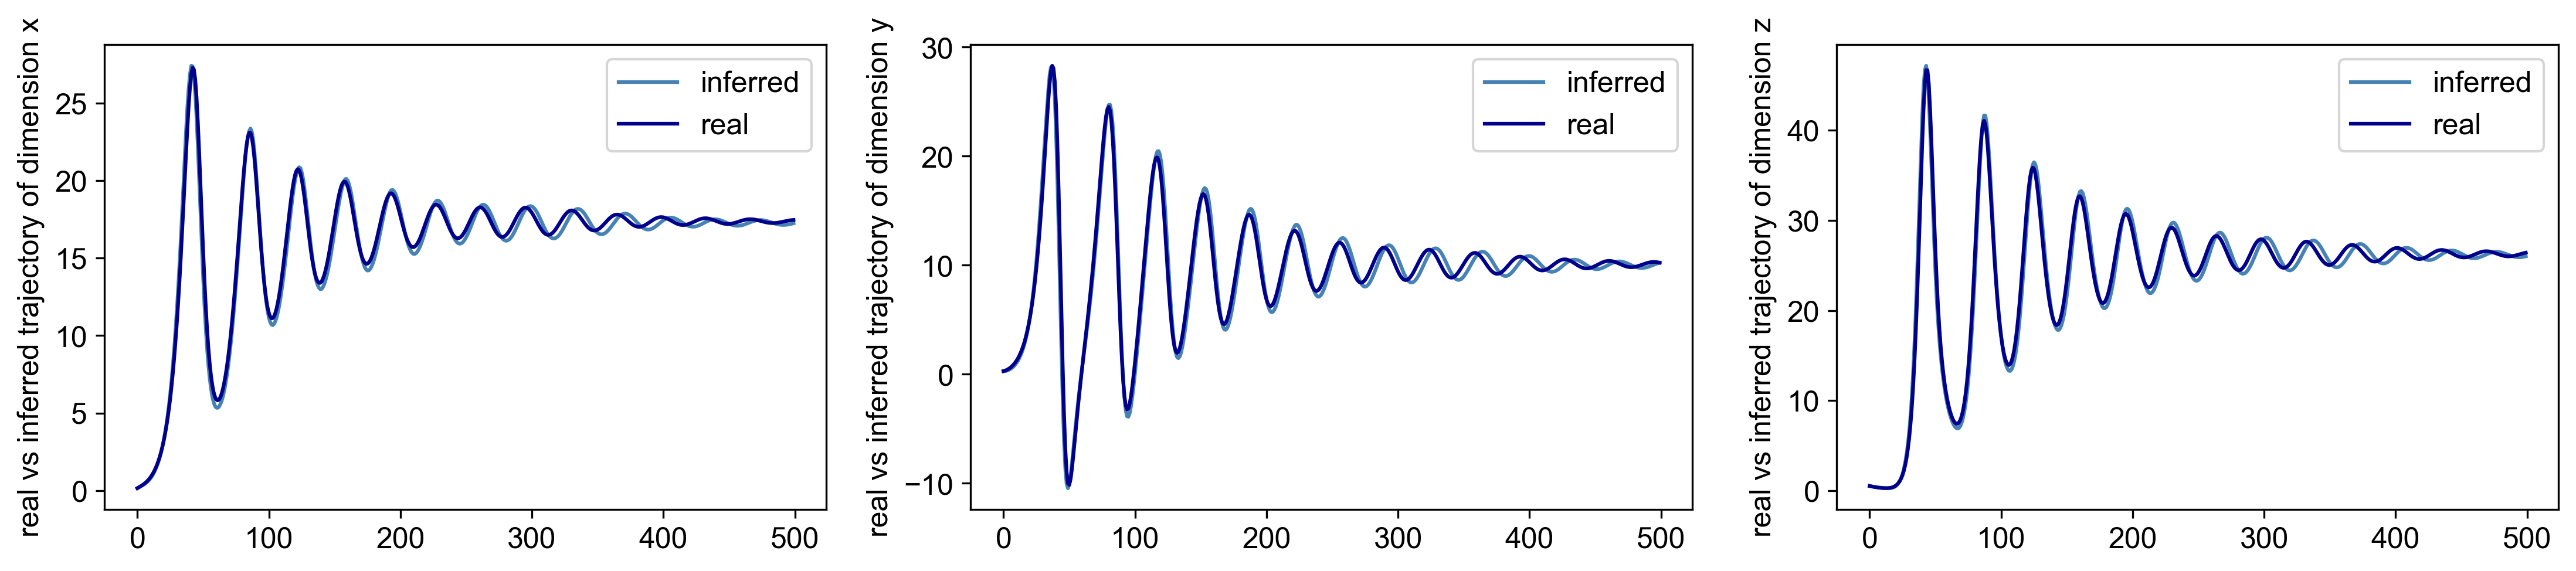

In [518]:
time1 = pd.read_csv('../Network-SDE-Inference/Data/TimeSeries&Topologies/Lorenz_determ_in005_200.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
x_tra = x_i.detach().numpy()[0:500,0]
x_real = time1.iloc[:,0]
fig = plt.figure(figsize=(18,3.5))
ax1 = fig.add_subplot(1,3,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[1:x_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
y_tra = y_i.detach().numpy()[0:500,0]
y_real = time1.iloc[:,1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[1:y_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
z_tra = z_i.detach().numpy()[0:500,0]
z_real = time1.iloc[:,2]
t = np.arange(0,z_tra.shape[0])
ax3.plot(t,z_tra,c='steelblue',label="inferred")
ax3.plot(t, z_real[1:z_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension z')
plt.legend()
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_trajectory_fig2.pdf')
plt.show()
plt.close()

In [473]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(msg_dim)])

In [474]:
bestMe = messages_over_time[-1][['e%d'%(best_message),'x1','x2']]

In [475]:
#coup_value = 0.15*(2-bestMe['x1'].values)/(1+np.exp(-10*(bestMe['x2'].values-1))) # x1 (x_i) is target, x2 (x_j) is source 
coup_value = bestMe['x2'].values

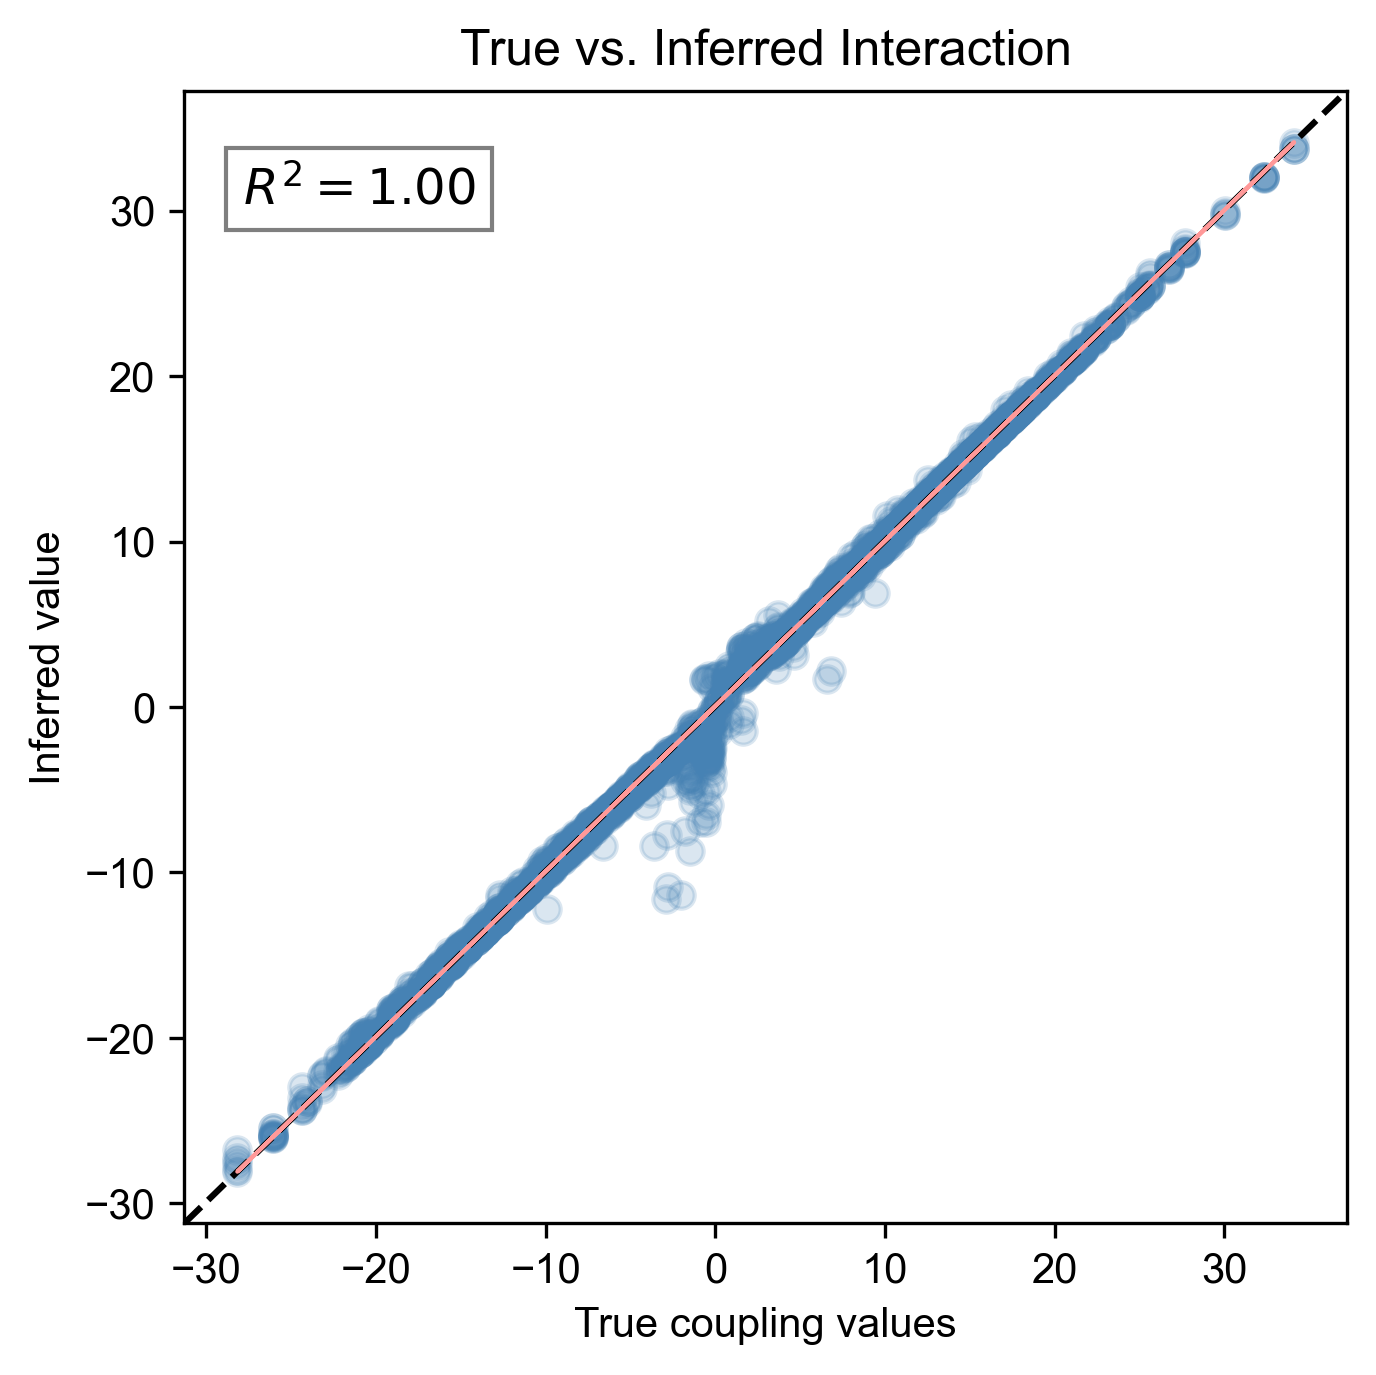

In [519]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(msg_dim)])
bestMe = messages_over_time[-1][['e%d'%(best_message),'x1','x2']]
temp = bestMe.iloc[:,0].values
coup_value = coup_value[0:5000]
temp = temp[0:5000]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=40,c ='steelblue', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.0)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
plt.title('True vs. Inferred Interaction')
plt.xlabel("True coupling values")
plt.ylabel("Inferred value")
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_interaction_fig2.pdf')
plt.show()
plt.close()


In [477]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)

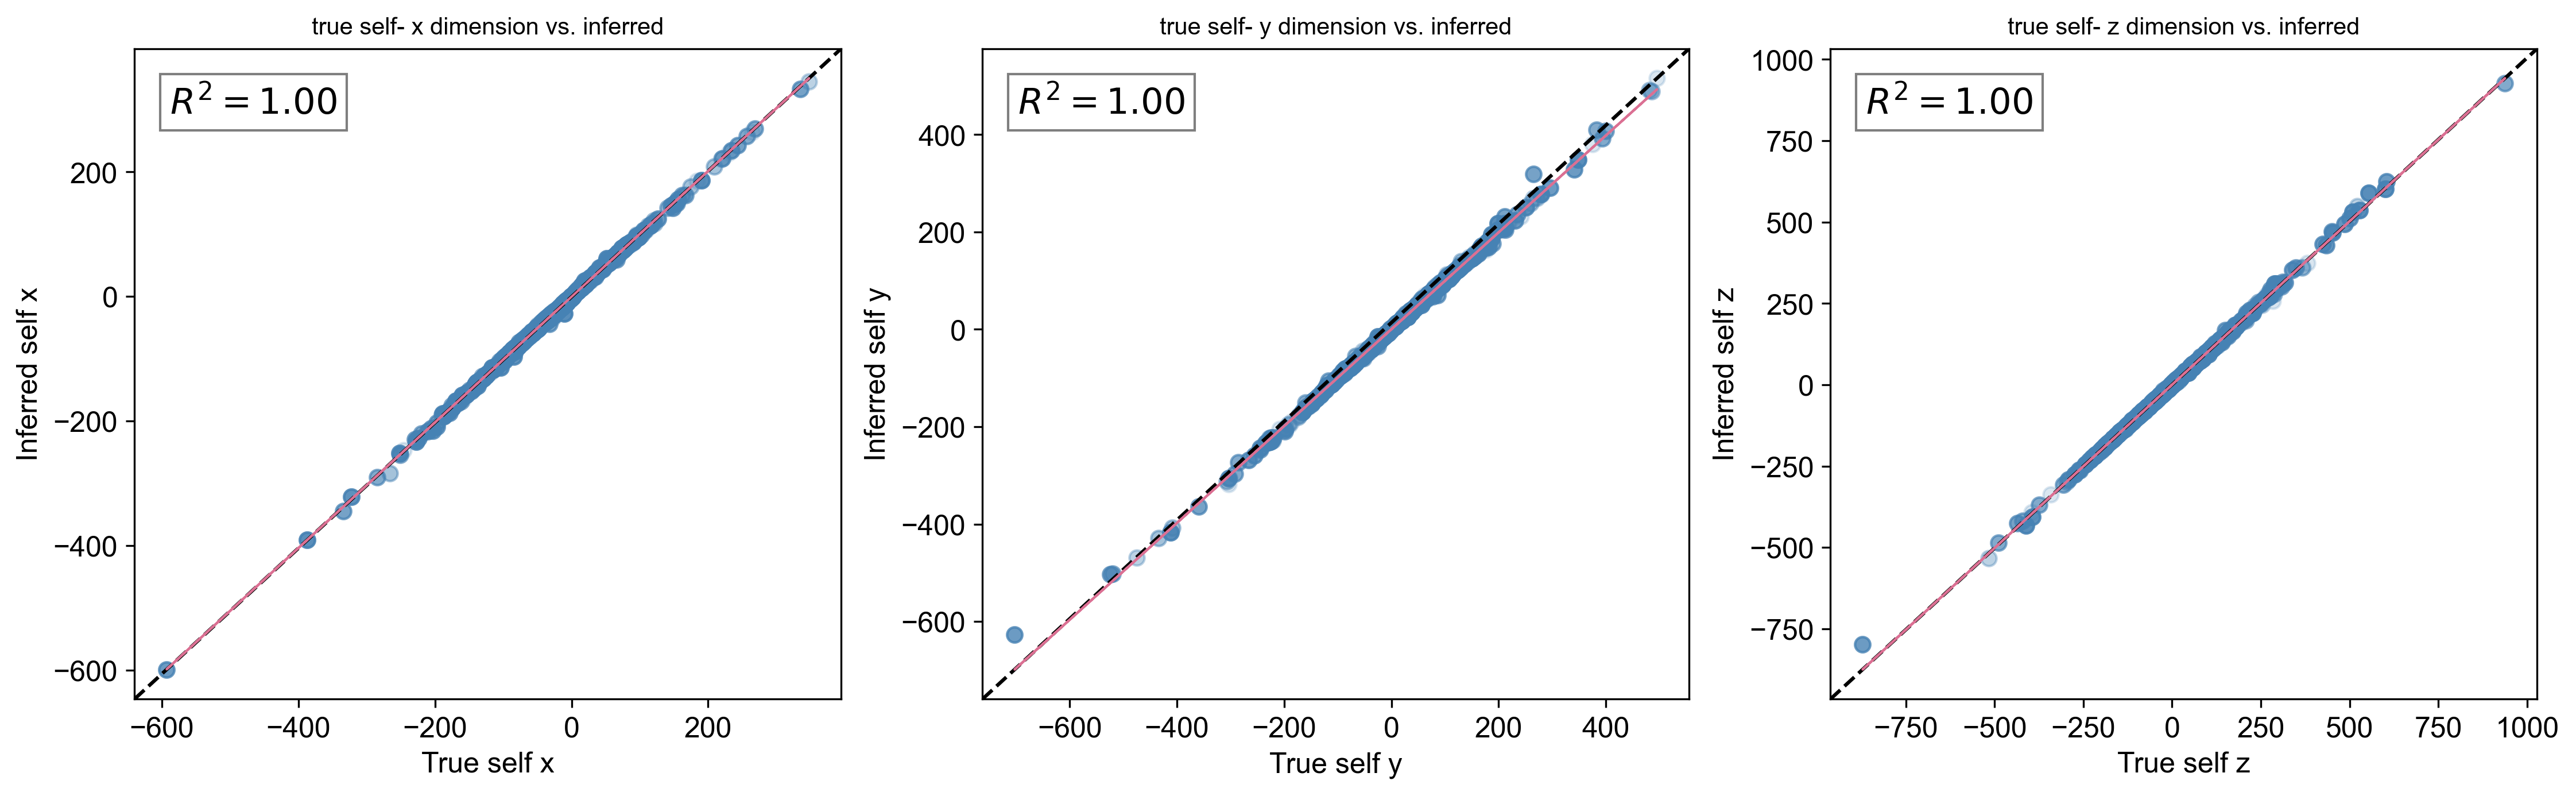

In [520]:
gamma = 1
sx = best_selfDyn['s1'].values
sx_true = 10*best_selfDyn['y']-(10+2/gamma)*best_selfDyn['x']
sy = best_selfDyn['s2'].values
sy_true = (28-best_selfDyn['z'])*best_selfDyn['x']-(1+2/gamma)*best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = best_selfDyn['x']*best_selfDyn['y']-(8/3+4/gamma)*best_selfDyn['z']

plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
sx = best_selfDyn['s1'].values
# sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
# sy = best_selfDyn['s2'].values
# sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
# sz = best_selfDyn['s3'].values
# sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])
sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=40,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true self- y dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=40,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=1)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True self y")
plt.ylabel("Inferred self y")


ax3 = fig.add_subplot(1,3,3)
plt.title("true self- z dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=40,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=1)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True self z")
plt.ylabel("Inferred self z")
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_fig2.pdf')
plt.show()
plt.close()

## Learn the stochastic differential equations

In [479]:
import Self_func

In [480]:
import Interaction_func

In [481]:
from Self_func import *
from Interaction_func import *

In [482]:
"""Construct the elementary matrix with pre-defined library"""
xi = bestMe['x1'].values
xj = bestMe['x2'].values
Matrix = ElementaryFunctions_Matrix(xi,xj)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:114: RuntimeWarning: overflow encountered in exp
  tmp2 = np.exp(xi*xj)
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:141: RuntimeWarning: overflow encountered in exp
  sigmoidOutput = 1/(1+np.exp(-alpha*(x-beta)))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: overflow encountered in exp
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: invalid value encountered in true_divide
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


In [483]:
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [484]:
goal = bestMe['e0'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['e0'])

In [485]:
X = Matrix.copy()
y = goal.copy()

In [486]:
"""Normalization process, eliminate order of magnitude differences"""
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [487]:
reg1 = LassoCV(cv=5, fit_intercept=False, n_jobs=-1, max_iter=1000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.998284559747808
Best threshold: 0.004


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [488]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

In [489]:
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
fracxixj              -0.000021
xifracxj               0.000619
xisinxj                0.001947
fracxj                 0.002733
sinxj                  0.003039
xisigmoidxj101         0.011152
sigmoidXjMinusXi101    0.041135
sigmoidxj101           0.041800
tanhxj                 0.305873
xj                     0.968971
dtype: float64


In [490]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 

In [491]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LassoCV(cv=5, fit_intercept=intercept,  n_jobs=-1, max_iter=1000, normalize=False).fit(X_lib,Y_goal)
    coef = pd.Series(reg.coef_, index=X_lib.columns)
    if intercept == True:
        coef['constant'] = reg.intercept_
        num_params = len(coef)
    else:
        num_params = len(coef)    
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    sort = coef.sort_values()
    print(coef)
    return Score, mse, aic

In [492]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = Matrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = Matrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X)
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    if Score>0.95:
        break

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0    1.000574
dtype: float32
0.9979641597857751 0.28054515 -127100.06212542194 xj


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


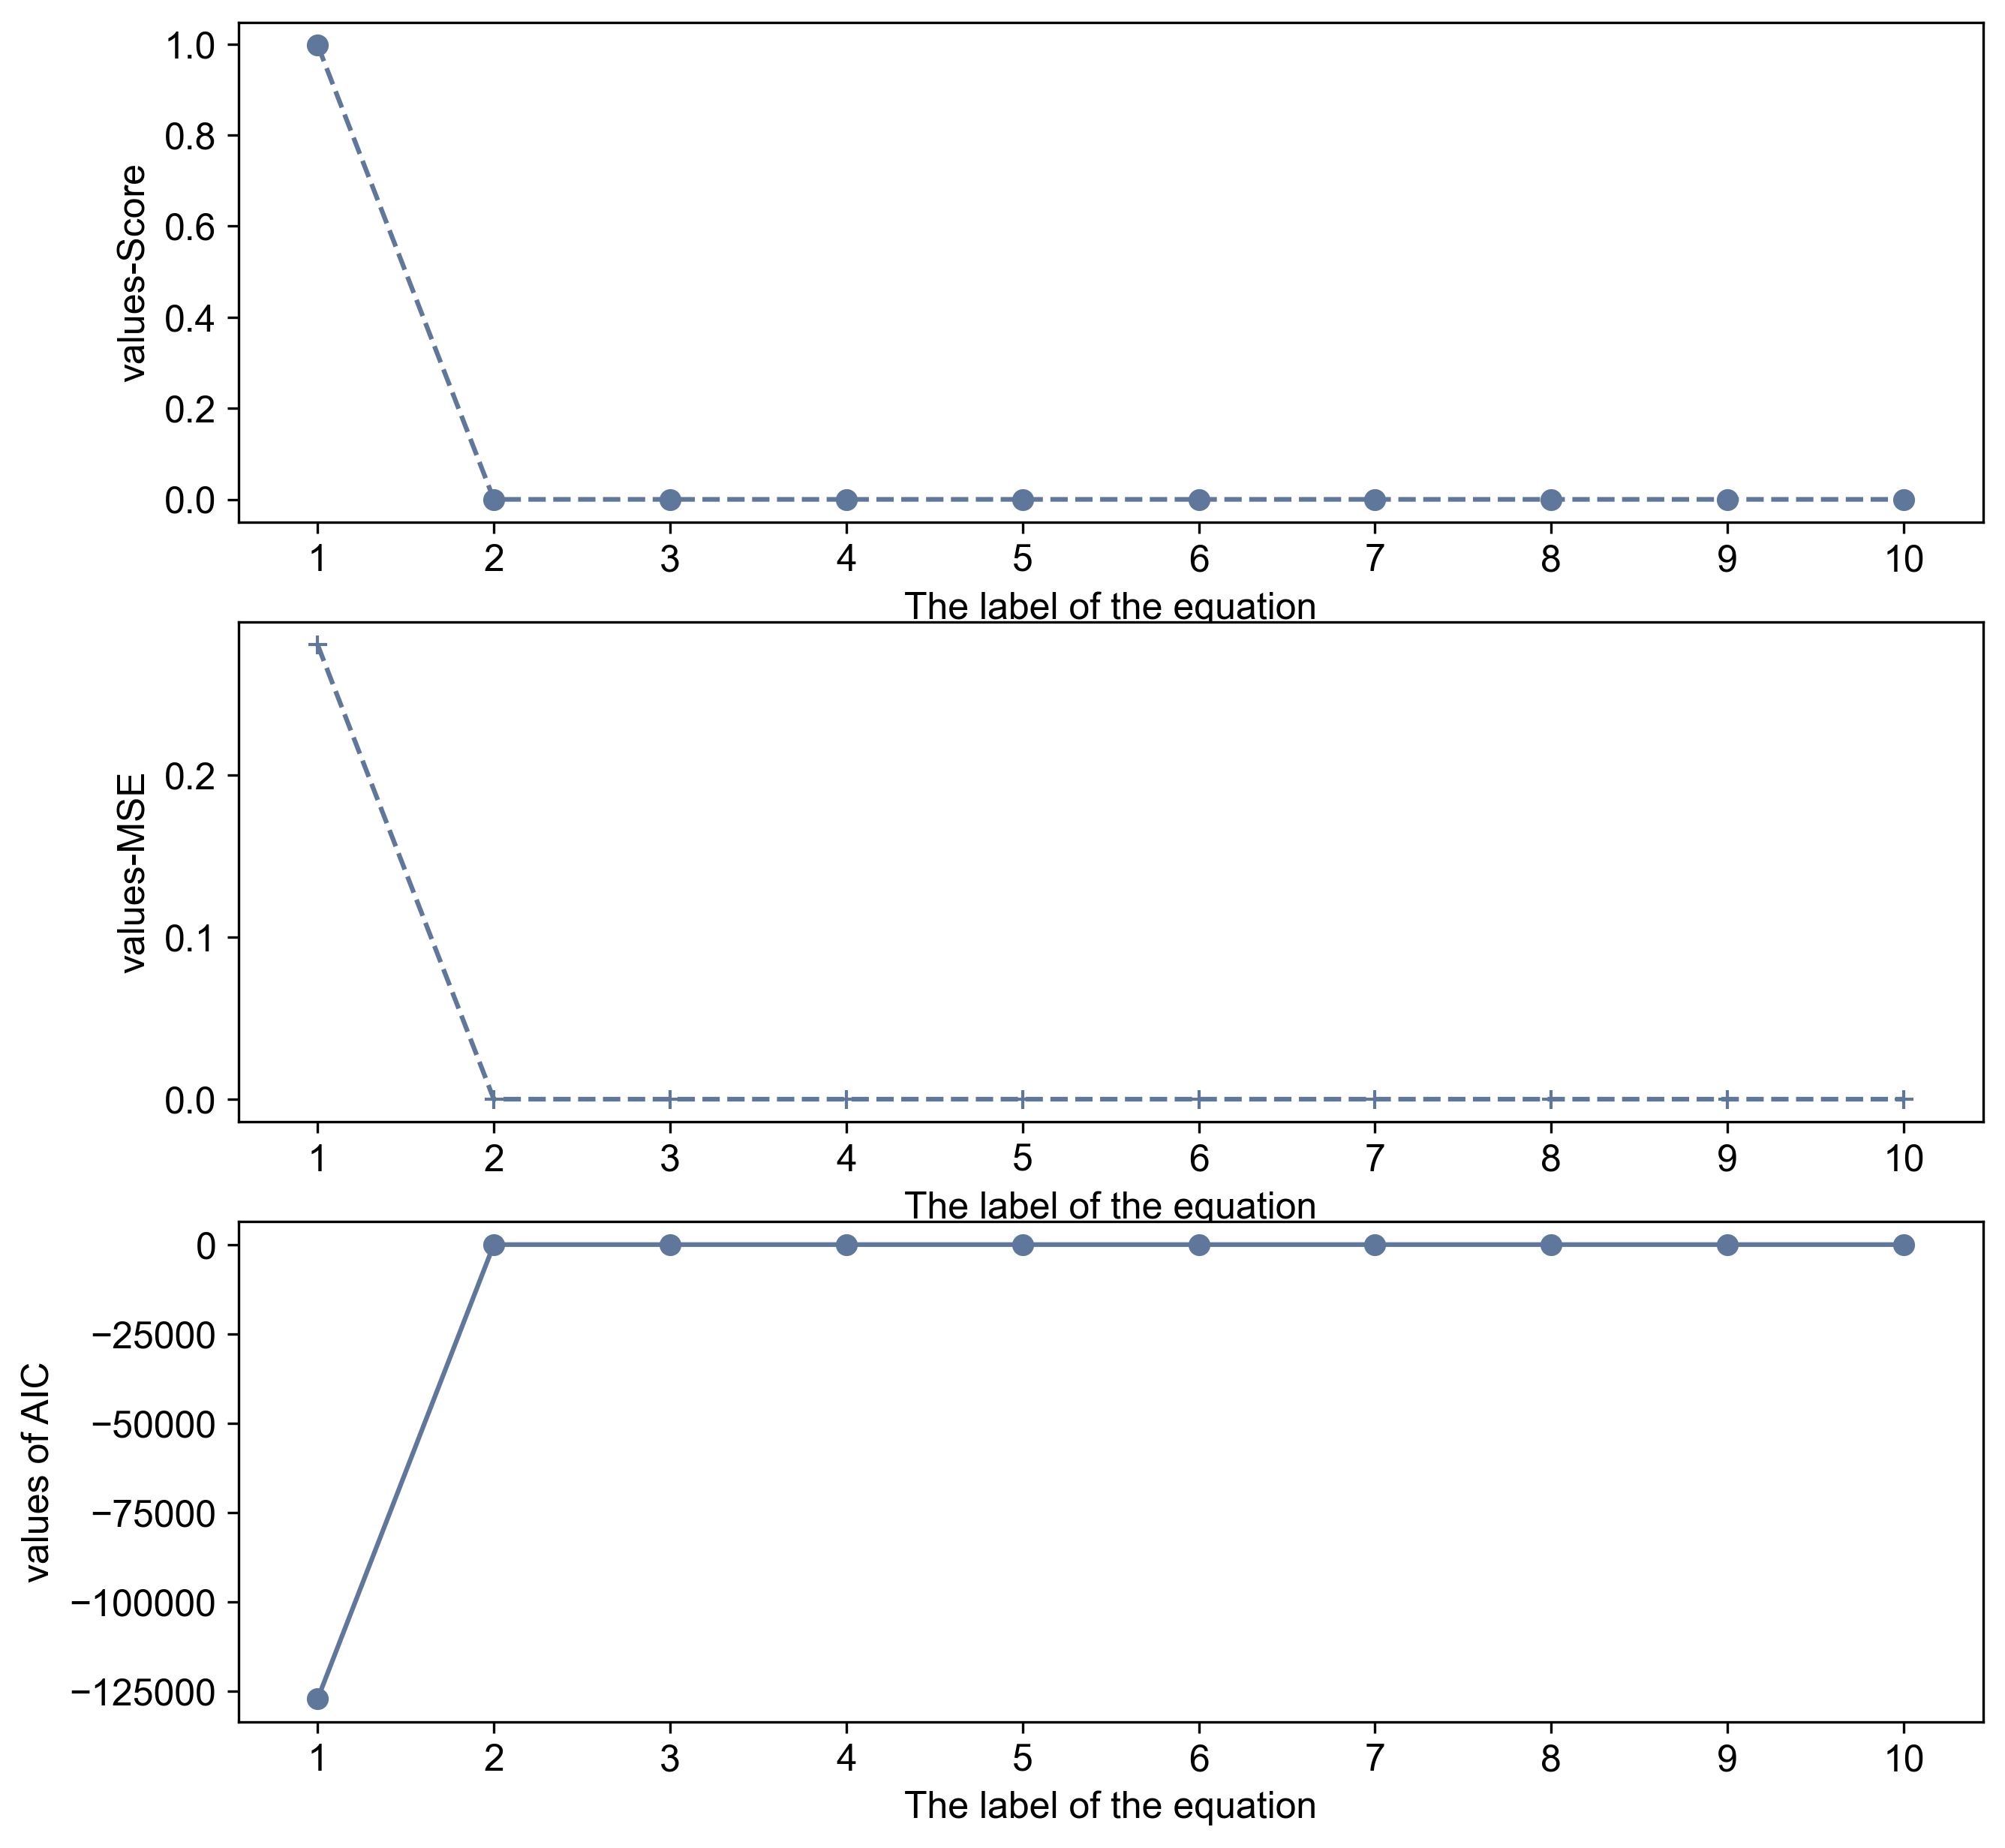

In [493]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()

In [494]:
xi = bestMe['x1'].values
xj = bestMe['x2'].values
Matrix = ElementaryFunctions_Matrix(xi,xj)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = bestMe['e0'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['e0'])
X = Matrix.copy()
y = goal.copy()

/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:114: RuntimeWarning: overflow encountered in exp
  tmp2 = np.exp(xi*xj)
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:141: RuntimeWarning: overflow encountered in exp
  sigmoidOutput = 1/(1+np.exp(-alpha*(x-beta)))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: overflow encountered in exp
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: invalid value encountered in true_divide
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


In [495]:
Xfind = X['xj'].values.reshape(-1,1)
yfind = y['e0']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
print(a)

[1.0015744]


In [496]:
error_int = abs(a-1)/(abs(a)+1)
print('The error of interaction part:',error_int)

The error of interaction part: [0.00078658]


In [497]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [498]:
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [499]:
goal = best_selfDyn['s1'].values
goal = pd.DataFrame(data = goal, columns =['s1'])

In [500]:
X = self_matrix.copy()
y = goal.copy()

In [501]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [502]:
reg1 = LassoCV(cv=5, fit_intercept=False, n_jobs=-1, max_iter=5000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.9991183355806511
Best threshold: 0.006


In [503]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [504]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
#imp_cons = imp_cons.sort_values(key=abs)
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x2x2x3x3    3.402874e-07
x1x2x2x2    2.690227e-06
x1x1x1x1   -4.364229e-06
x2x2x2x3    5.281792e-06
x2x2x2      1.582704e-04
x1x1x1     -4.098657e-04
x1x1       -2.305346e-03
x1x3       -4.437107e-03
x2          9.677019e+00
x1         -1.157163e+01
dtype: float64


In [505]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = self_matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = self_matrix.copy()[imp_cons.index[-i]].values.reshape(-1,1)
            X = pd.DataFrame(X)
        else:
            X = pd.concat([X,tmp],axis=1)
        Score, mse, aic = terms_sort_fit(X,y,False)
    else:
        Score, mse, aic = terms_sort_fit(X,y,True)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])
    if Score>0.997:
        break

0   -3.376604
dtype: float64
0.17539433385753533 5984.239025168461 869690.4462902104 x1
0    -12.104348
x2    10.054381
dtype: float64
0.9993006445054974 5.0752870305229685 162442.30810670383 x2


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/a

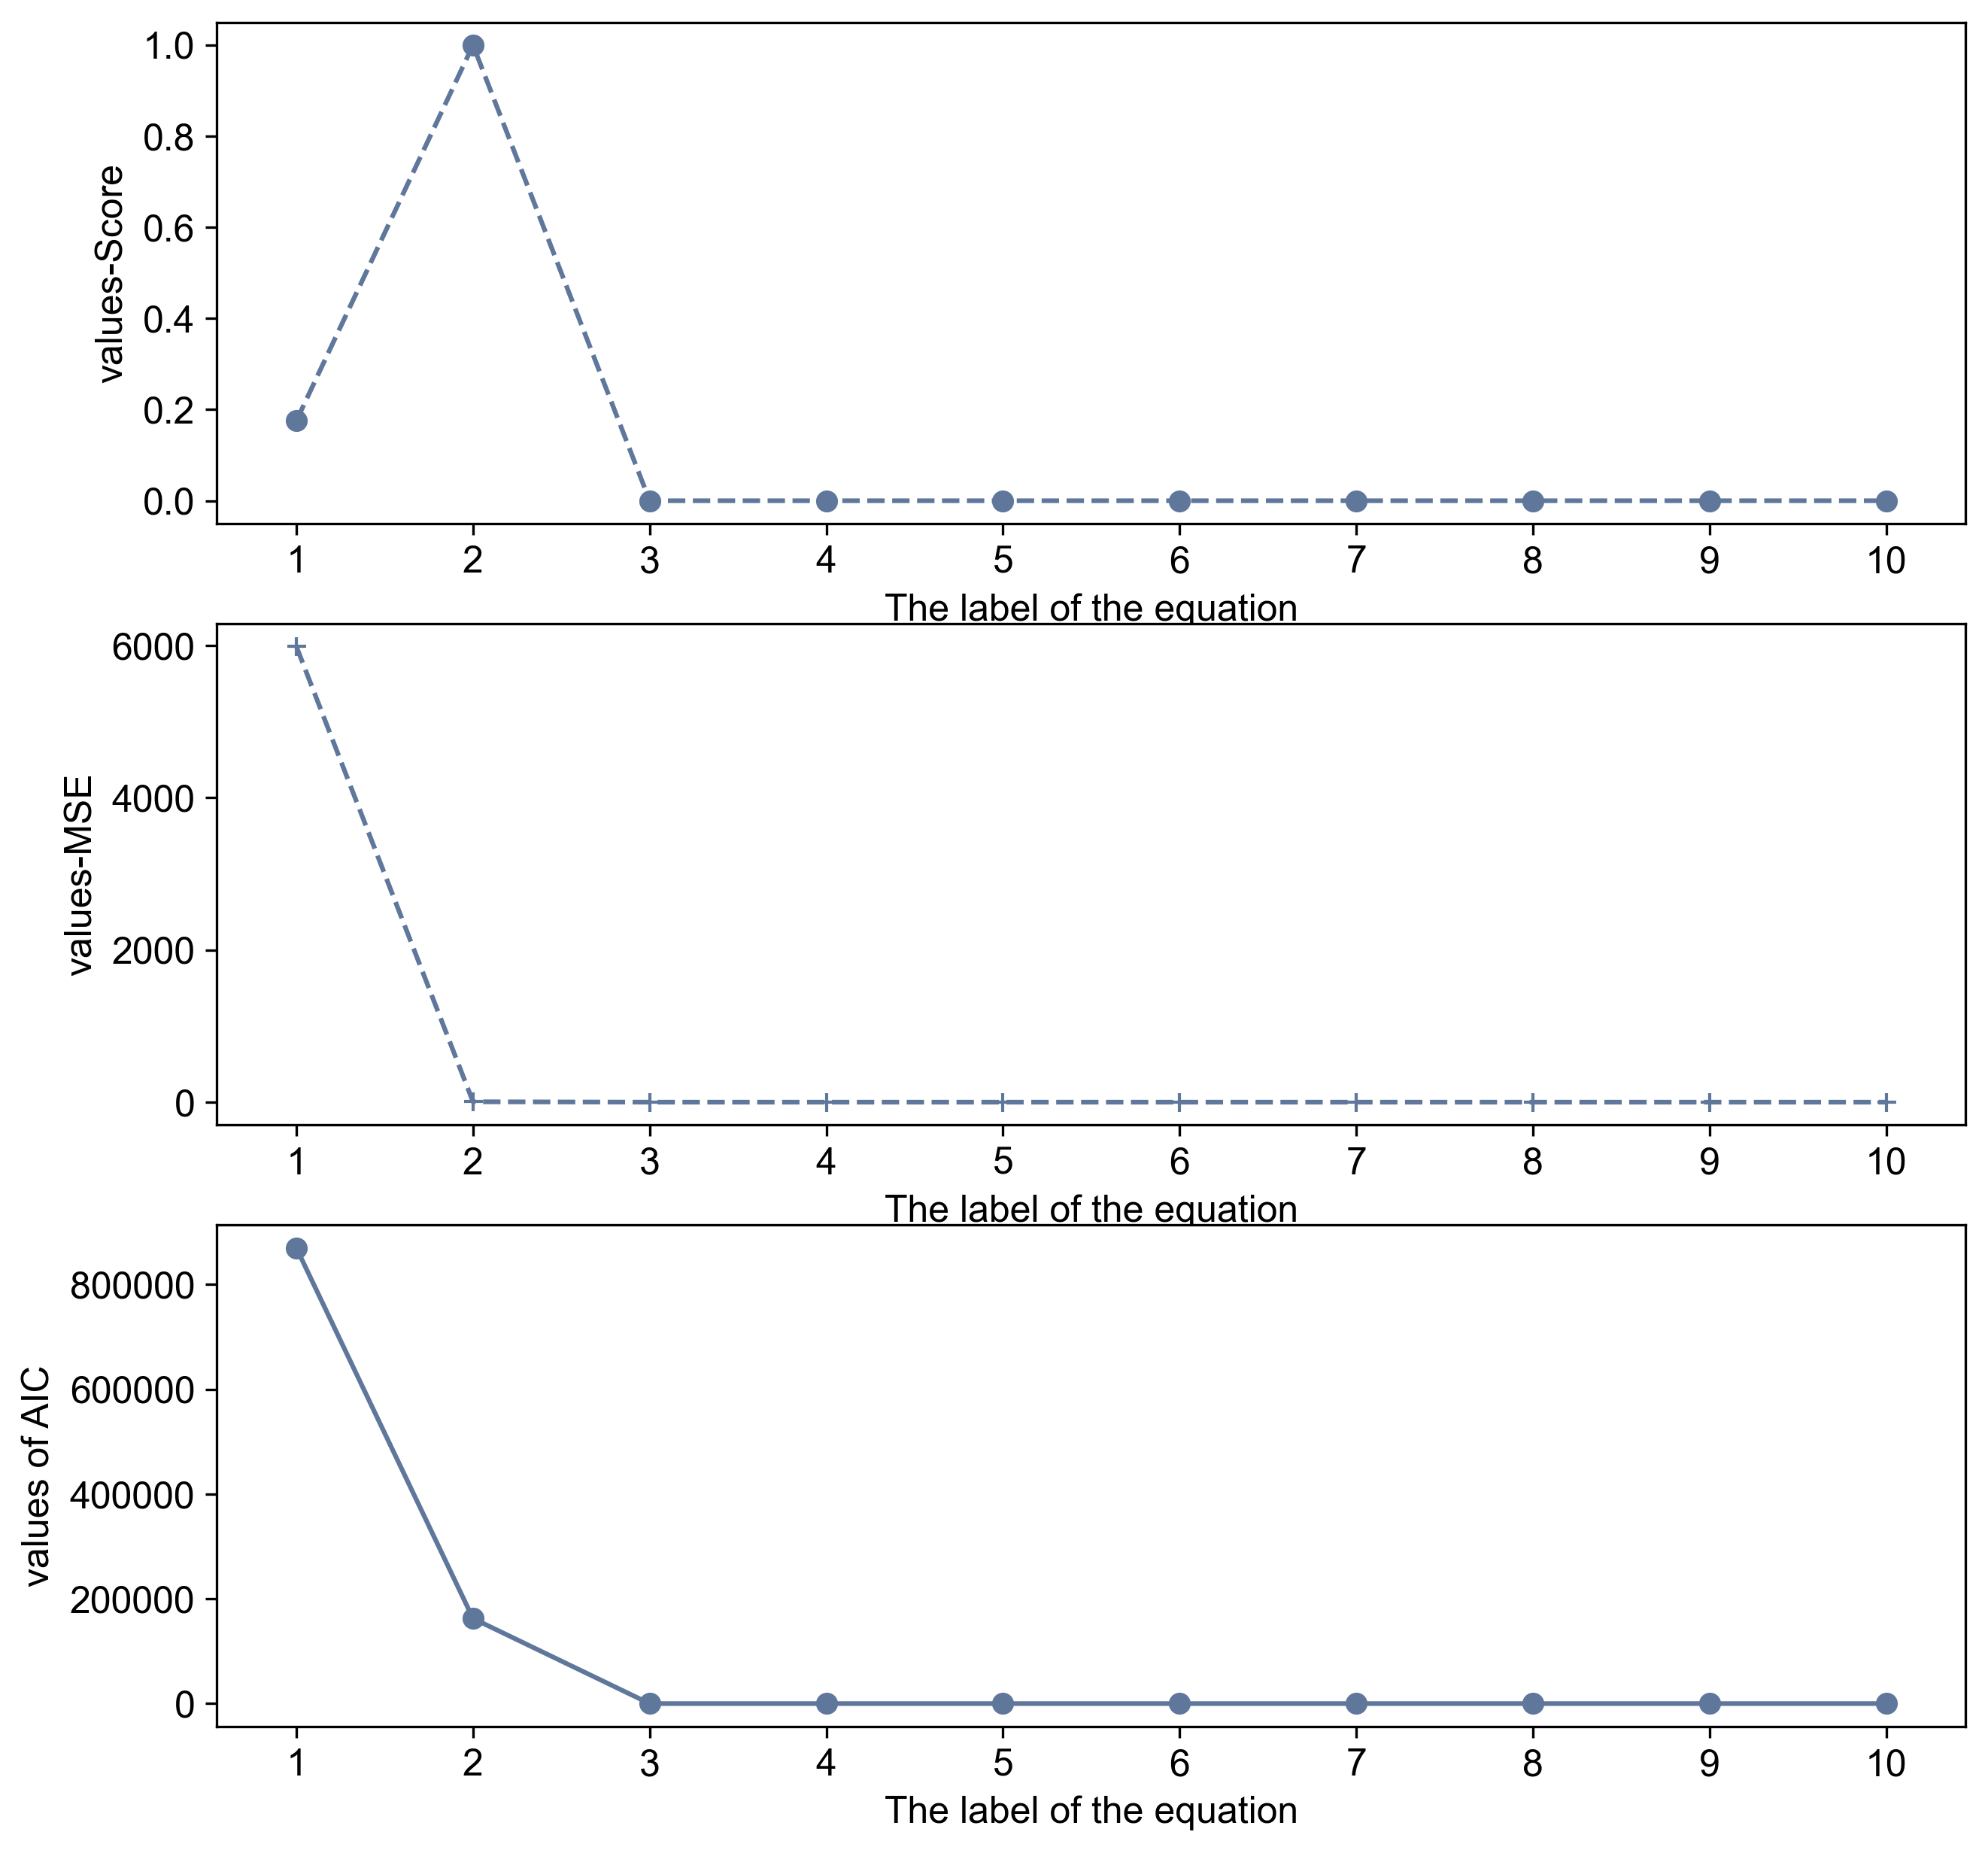

In [506]:
# Visualization
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()

# Calculate the inference error 

In [507]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = best_selfDyn['s1'].values
goal = pd.DataFrame(data = goal, columns =['s1'])
X = self_matrix.copy()
y = goal.copy()

In [508]:
Xfind = pd.concat([X['x1'],X['x2']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s1']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
a

array([-12.12511225,  10.07386531])

In [509]:
model_linear.intercept_

0.0

In [510]:
error_self1 = abs(a[0]-[-12])/(abs(a[0])+abs(-12))

In [511]:
error_int

array([0.00078658], dtype=float32)

In [512]:
error_self2 = abs(a[1]-[10])/(abs(a[1])+abs(10))

In [513]:
Error = (error_self1+error_self2+error_int)/3

In [514]:
Error

array([0.00321741])

In [544]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = best_selfDyn['s3'].values
goal = pd.DataFrame(data = goal, columns =['s3'])
X = self_matrix.copy()
y = goal.copy()

In [545]:
Xfind = pd.concat([X['x1x2'],X['x3']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s3']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
a

array([ 1.00233568, -6.67988203])